# A/B - testing

In [1]:
# the code is for study epsilon-greedy stretagy of A/B testing

In [11]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from   scipy.stats import norm,bernoulli

In [3]:
np.random.seed(0)

In [4]:
class bandits:
    ''' class to create bandit sample'''
    def __init__(self,prob):
        self.prob = prob
    def pull(self,j):
        reward = bernoulli.rvs(p = self.prob[j])
        return reward 

In [5]:
def experiment(eps,bandit_prob,num_step,k,optimistic):
    '''produce the process of bandit selection
       input:
       - eps         - param of epsilon greedy strategy,
       - bandit_prob - list of bandits' rewards,
       - num_step    - number of repeating,
       - k : eps_t = max(eps =k*t, 0.01),
       - optimistic = 1 for optimistic start
       out:
       - df with bandit number, reward for every step
       - bandits_means'''
    k = 2/num_step
    bandits_mean = [0.5,0.5,0.5]
    j_set      = []
    rewards    = []
    reward_sum = []
    bandits_mean_list1 = []
    bandits_mean_list2 = []
    bandits_mean_list3 = []
    bandits_mean = [0.5,0.5,0.5]
    # for optimistic start:
    if optimistic == 1 :bandits_mean = [10,10,10]
    bandits_step = [0,0,0]
    reward_s = 0
    low  = 0
    high = len(bandit_prob)
    j_max = np.random.randint(low, high)
    
    for i in range(num_step):
        n_step = i + 1
        # choose bandit
        p = np.random.random()
        eps_t = get_eps_t(k,i)
        j = get_j_esp_greedy(j_max,p,eps_t,low, high)
        #j = get_j_ucb1(n_step,bandits_mean,bandits_step)
        # do step
        reward = bandit.pull(j)
        # calculate new mean
        bandits_mean, bandits_step = new_mean(reward,j,bandits_mean, bandits_step)
        # check for max
        j_max = np.argmax(bandits_mean)
        # save j and rewards
        j_set.append(j)
        rewards.append(reward)
        bandits_mean_list1.append(bandits_mean[0])
        bandits_mean_list2.append(bandits_mean[1])
        bandits_mean_list3.append(bandits_mean[2])
        reward_s = reward_s + reward
        reward_sum.append(reward_s)
    ind = [i+1 for i in range(num_step)]
    df = pd.DataFrame({'bandits_index': j_set,'reward':rewards,'reward_sum':reward_sum}, index = ind)
    bandits_mean_df1 = pd.DataFrame({'bandits_mean': bandits_mean_list1}, index = ind)
    bandits_mean_df2 = pd.DataFrame({'bandits_mean': bandits_mean_list2}, index = ind)
    bandits_mean_df3 = pd.DataFrame({'bandits_mean': bandits_mean_list3}, index = ind)
    bandits_means =[bandits_mean_df1,bandits_mean_df2,bandits_mean_df3]
    return df , bandits_means
def get_eps_t(k,i):
    '''function to calculate eps for every step of the process'''
    eps_t = max(eps - k*i,0.001)
    return eps_t
def new_mean(reward,j,bandits_mean, bandits_step):
    ''' function to culculate mean rewards for bandits during process'''
    n_step          = bandits_step[j] + 1
    bandits_mean[j] = bandits_mean[j]*(n_step-1)/n_step + reward/n_step
    bandits_step[j] = n_step
    return bandits_mean, bandits_step
def get_j_esp_greedy(j_max,p,eps_t,low, high):
    ''' determ j epsilon greedy strategy'''
    if p < eps_t:
        j = np.random.randint(low, high)
    else:
        j = j_max
    return j
def get_j_ucb1(n_step,bandits_mean,bandits_step):
    ucb = []
    for i in range(len(bandits_mean)):
        ucb.append(bandits_mean[i] + np.sqrt(2*log(n_step/bandits_mean[i])))
    j = np.argmax(ucb)
    return j

In [6]:
def out(res,bandits_means,n_from,n_to):
    '''show result
    - n_from - first step to show
    - n_to   - last  step to show for 3th and 4th'''
    total_result         = res.reward.sum()
    bandit_prob_max      = np.max(bandit_prob)
    best_possible_result = num_step * bandit_prob_max
    optimal  = [i* bandit_prob_max for i in range(num_step)]
    print('epsilon = ', eps)
    print('total reward         = ',total_result)
    print('the best possible result = ',best_possible_result)
    print("efficincy : total reward/the best possible result = ",total_result/best_possible_result)
    fig,ax  = plt.subplots(2,2,figsize = (14,14))
    #ax_axis =  ax[0].twinx()
    n_show = min(n_to,res.shape[0])
    res1 = res.loc[n_from:n_show,:]
    ax[0,0].plot(res1.index.to_numpy(), res1.reward.to_numpy() ,                  label = 'reward')
    ax[0,1].scatter(res1.index.to_numpy(), (res1.bandits_index+1).to_numpy(), ls = "--", label = "bandit's number")
    ax[0,0].set_title(f'Reward for step (from {n_from} to {n_show} steps)')
    ax[0,0].set_xlabel('process step')
    ax[0,0].set_ylabel('reward')
    ax[0,1].set_ylabel("bandit's number")
    ax[0,1].set_title(f"Bandit's number (from {n_from} to {n_show} steps)")
    ax[0,0].legend(['reward',"bandit's number"] )
    ax[1,0].set_ylabel('sum of rewards')
    ax[1,0].plot(res.index.to_numpy(), res.reward_sum.to_numpy())
    ax[1,0].plot(res.index.to_numpy(), optimal)
    ax[1,0].axhline(best_possible_result, ls ="--",color = 'red')
    ax[1,0].set_title('Sum of rewards')
    ax[1,0].set_xlabel('process step')
    ax[1,0].legend(['sum of rewards','optimal way','max possible reward'] )
    for i in range(len(bandits_means)):
        dfi = bandits_means[i]
        ax[1,1].plot(dfi.index.to_numpy(), dfi.bandits_mean.to_numpy() , label = f"bandit {i+1}")
    ax[1,1].legend(['1','2','3'])
    ax[1,1].set_title("Bandits' means")
    ax[1,1].axhline(bandit_prob[0], ls ="--",color = 'blue', label = 'prob 1')
    ax[1,1].axhline(bandit_prob[1], ls ="--",color = 'blue', label = 'prob 2')
    ax[1,1].axhline(bandit_prob[2], ls ="--",color = 'blue', label = 'prob 3')
    plt.show() 

In [7]:
# create an instance of bandit
bandit_prob = [0.25, 0.5, 0.75]
bandit = bandits(bandit_prob)

In [8]:
num_step = 100
eps = 0.2
k = 1.5/num_step
optimistic = 1

In [9]:
res, bandits_means = experiment(eps,bandit_prob,num_step,k,optimistic)

epsilon =  0.2
total reward         =  67
the best possible result =  75.0
efficincy : total reward/the best possible result =  0.8933333333333333


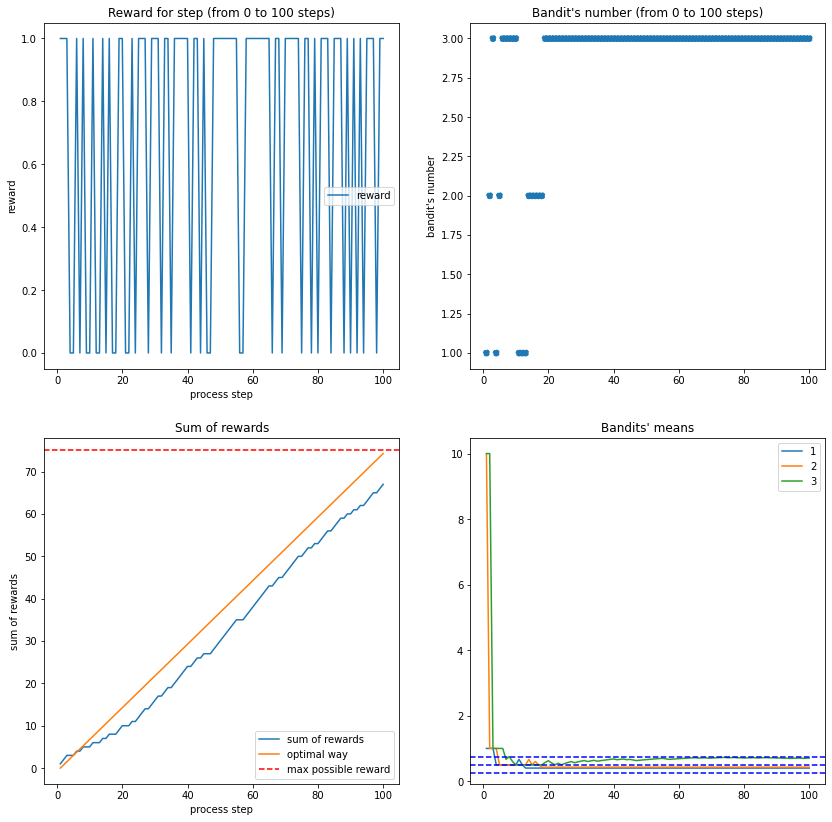

In [10]:
n_from = 0
n_to   = 100
out(res,bandits_means,n_from,n_to) 